# Relazione Finale
**Gruppo - Dig Data**

**Componenti Gruppo - Alexandru Pavel, Simone Garzarella**

# Indice
- [3. Introduzione](#introduction)
    - [3.1. Descrizione Problema](#problem-description)
    - [3.2. Specifiche Software](#hw-specs)
- [4. Analisi Dataset](#data-analysis)
    - [4.1. Historical Stock Prices](#hsp)
    - [4.2. Historical Stocks](#hs)
- [5. Job 1](#job1)
    - [5.1. MapReduce](#mapreduce1)
    - [5.2. Hive](#hive1)
    - [5.3. Spark](#spark1)
- [6. Job 2](#job2)
    - [6.1. MapReduce](#mapreduce2)
    - [6.2. Hive](#hive2)
    - [6.3. Spark](#spark2)
- [7. Job 3](#job3)
    - [7.1. MapReduce](#mapreduce3)
    - [7.2. Hive](#hive3)
    - [7.3. Spark](#spark3)
- [8. Risultati](#results)
    - [8.1. Job 1](#plot1)
    - [8.2. Job 2](#plot2)
    - [8.3. Job 3](#plot3)
- [9. Conclusioni](#conclusions)

# Introduzione <a name="introduction"></a>
Il dataset "Daily Historical Stock Prices" contiene l'andamento delle azioni sulla borsa di New York (NYSE e NASDAQ) dal 1970 al 2018. 

Due file CSV compongono il dataset:
- historical_stock_prices.csv
- historical_stocks.csv

Il primo contiene i valori dei prezzi e volumi che variano nel tempo per ogni ticker. Il secondo i dati relativi ad ogni ticker, come il settore e l'exchange in cui è quotato.

## Descrizione Problema <a name="problem-description"></a>
Dopo una fase iniziale di analisi e processamento di dati si vogliono eseguire 3 job (descritti nel dettaglio più avanti) con le diverse tecnologie affrontate nel corso (Hadoop, Hive e Apache Spark).

## Specifiche Hardware <a name="hw-specs"></a>
I test sono stati eseguiti in locale e su cluster con macchine con queste caratteristiche:
- **Locale:** Ubuntu 20.04, CPU i5 2.5GHZ, 8GB Ram e 256GB SSD
- **Cluster:** AWS EMR con 1 Master Node e 5 DataNode. Istanze m5.xlarge con 16GB RAM, 4 vCPU e 64GB di spazio.

# Analisi Dataset <a name="data-analysis"></a>

Di seguito vengono analizzati i due file del dataset per individuare eventuali preprocessamenti da effettuare. Inoltre viene anche descritto il processo per creare dataset più piccoli o grandi (con sampling) per effettuare i successivi test.

In [1]:
import pandas as pd

## Historical Stock Prices <a name="hsp"></a>

I campi di questo dataset sono:

- `ticker`: simbolo univoco dell’azione (https://en.wikipedia.org/wiki/Ticker_symbol)
- `open`: prezzo di apertura
- `close`: prezzo di chiusura
- `adj_close`: prezzo di chiusura “modificato”
- `lowThe`: prezzo minimo
- `highThe`: prezzo massimo
- `volume`: numero di transazioni
- `date`: data nel formato aaaa-mm-gg

In [2]:
stock_prices = pd.read_csv('dataset/historical_stock_prices.csv')

In [3]:
stock_prices

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14
...,...,...,...,...,...,...,...,...
20973884,NZF,14.60,14.59,14.590000,14.58,14.62,137500,2018-08-20
20973885,NZF,14.60,14.58,14.580000,14.57,14.61,151200,2018-08-21
20973886,NZF,14.58,14.59,14.590000,14.57,14.63,185400,2018-08-22
20973887,NZF,14.60,14.57,14.570000,14.57,14.64,135600,2018-08-23


Ci sono ~21milioni di record per questo file

In [4]:
stock_prices.isna().sum()

ticker       0
open         0
close        0
adj_close    0
low          0
high         0
volume       0
date         0
dtype: int64

Non sono presenti valori nulli per nessuna delle colonne

In [5]:
stock_prices.nunique()

ticker          5685
open          807688
close         835181
adj_close    9235753
low           815237
high          821044
volume        385849
date           12274
dtype: int64

In totale ci sono 5685 `ticker` univoci nel dataset

In [6]:
stock_prices[stock_prices.duplicated(subset=['ticker','date'])].shape

(0, 8)

Non ci sono record distinti con valori duplicati di (ticker, data)

### Creazione di dataset di varie dimensioni

Sono stati generati dataset di dimensioni (approssimativamente) di 256/512/1024MB e ~4GB, oltre al dataset originale che ha dimensioni ~2GB.

I file generati (con relativa dimensione precisa) hanno nome historical_stock_prices[size].csv

- historical_stock_prices`256`.csv &ensp;&ensp;(239.75MB)
- historical_stock_prices`512`.csv &ensp;&ensp;(479.51MB)
- historical_stock_prices`1024`.csv &ensp;(959.03MB)
- historical_stock_prices.csv &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;(1909.97MB)
- historical_stock_prices`4096`.csv &ensp;(3835.92MB)

La scelta dei record da includere è effettuata con un sampling randomico (con un seed preimpostato, per la ripetibiltà)

```python
def sample_all_sizes(historical_stock_prices_df):
    for size in [0.125, 0.25, 0.5, 2]:
        sample_n_rows = dataset_row_count * size
        sampled_df = dataset.sample(sample_n_rows)
        filename = 'dataset/historical_stock_prices[SIZE].csv')
        sampled_df.to_csv(filename)

```

## Historical Stocks <a name="hs"></a>

Il dataset con le informazioni sui ticker è così strutturato:

- `ticker`: simbolo dell’azione
- `exchange`: NYSE o NASDAQ
- `name`: nome dell’azienda
- `sector`: settore dell’azienda
- `industry`: industria di riferimento per l’azienda

In [7]:
stocks = pd.read_csv("dataset/historical_stocks.csv")

In [8]:
stocks

,ticker,exchange,name,sector,industry
0,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
1,PIHPP,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
2,TURN,NASDAQ,180 DEGREE CAPITAL CORP.,FINANCE,FINANCE/INVESTORS SERVICES
3,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES
4,FCCY,NASDAQ,1ST CONSTITUTION BANCORP (NJ),FINANCE,SAVINGS INSTITUTIONS
...,...,...,...,...,...
6455,ZOES,NYSE,"ZOE&#39;S KITCHEN, INC.",CONSUMER SERVICES,RESTAURANTS
6456,ZTS,NYSE,ZOETIS INC.,HEALTH CARE,MAJOR PHARMACEUTICALS
6457,ZTO,NYSE,ZTO EXPRESS (CAYMAN) INC.,TRANSPORTATION,TRUCKING FREIGHT/COURIER SERVICES
6458,ZUO,NYSE,"ZUORA, INC.",TECHNOLOGY,COMPUTER SOFTWARE: PREPACKAGED SOFTWARE


In [9]:
stocks.nunique()

ticker      6460
exchange       2
name        5462
sector        13
industry     136
dtype: int64

Sono presenti 6460 `ticker` univoci, come il numero di righe del dataset. Il ticker può essere considerato una chiave di questo dataset, il nome dell'azienda `name` invece no, ha delle ripetizioni.

In [10]:
stocks[stocks.duplicated(subset=['name'])].shape

(998, 5)

In particolare sono presenti 998 nomi di azienda duplicati. Nel resto del progetto non si considererà questo campo per identificare record (in particolare per il job3).

In [11]:
stocks['sector'].unique()

array(['FINANCE', 'CONSUMER SERVICES', 'TECHNOLOGY', 'PUBLIC UTILITIES',
       'CAPITAL GOODS', 'BASIC INDUSTRIES', 'HEALTH CARE',
       'CONSUMER DURABLES', nan, 'ENERGY', 'MISCELLANEOUS', 'SECTOR',
       'TRANSPORTATION', 'CONSUMER NON-DURABLES'], dtype=object)

Visualizzando i possibili valori di `sector` si può notare la presenza di un valore nullo.

In [12]:
stocks.isna().sum()

ticker         0
exchange       0
name           0
sector      1440
industry    1440
dtype: int64

Il campo `sector` presenta 1440 valori nulli, che vengono eliminati durante il preprocessing di questo dataset.

In [13]:
stocks_clean = stocks.loc[(stocks['sector'].notna())]

In [14]:
stocks_clean.shape

(5020, 5)

Il dataset pulito dai valori nulli del campo `sector` ha 5020 record. Verrà salvato come `historical_stocks_clean.csv`

```python
stocks_clean.to_csv('dataset/historical_stocks_clean.csv')
```

# Job 1 <a name="job1"></a>

Deve generare un report contenente, per ciascuna azione:

- data prima quotazione (a)
- data ultima quotazione (b)
- variazione percentuale della quotazione (tra primo e ultimo prezzo di chiusura nel dataset) (c)
- prezzo massimo (d) 
- prezzo minimo (e)

Il report deve essere ordinato per valori decrescenti del secondo punto (dalla data di quotazione più recente alla più vecchia).

## MapReduce <a name="mapreduce1"></a>

Durante la fase di Map dapprima si estraggono i campi (mediante split e parsing) di ticker, closePrice, minPrice, maxPrice e date. Queste righe filtrate vengono mandate al Reducer che farà altre operazioni.

```python
class mapper:
    
    for row in INPUT:
        # split the current row into fields (ignoring not needed ones)
        ticker, closePrice, minPrice, maxPrice, date = row

        # write the separated fields to standard output
        print(ticker, closePrice, minPrice, maxPrice, date)
```

Nel Reducer dapprima si definisce una struttura dati dizionario (results) che conterrà, per ogni ticker, un dizionario con i valori richiesti dal job.

`results` ha il seguente formato per le sue entry: (ticker): (first_quot_date, last_quot_date, perc_var, min_price, max_price)

```python    
class reducer:
    
    # maps each ticker to the required values to calculate
    # for example: {'AAPL': {'min': 1, 'max': 2, ..},
    #               'AMZN': {'min': 0.5, 'max': 5, ..}}
    results = {}
```

Vengono parsati i valori provenienti dal Mapper, e per ogni ticker se esso non è già presente nel dizionario si inizializzano i suoi valori.

```python
    for row in INPUT:        
        # split the current row into fields
        ticker, closePrice, minPrice, maxPrice, date = row

        # if the ticker hasn't been seen before, initialize its values in the dictionary
        if ticker not in results:
            results[ticker] = {
                'first_quot_date': date,
                'last_quot_date': date,
                'first_quot_price': closePrice,
                'last_quot_price': closePrice,
                'perc_var': 0,
                'min_price': minPrice,
                'max_price': maxPrice
            }
            continue
```

I ticker già contenuti in results verranno aggiornati solo se necessario (ad esempio se si trova un ticker con una data di quotazione antecedente a quella salvata).

```python
# gets the input ticker's current saved values from the dictionary
        currTicker = results[ticker]

        # update the saved ticker values with the ones from the input data
        if date < currTicker['first_quot_date']:
            currTicker['first_quot_date'] = date
            currTicker['first_quot_price'] = closePrice
            
        if date > currTicker['last_quot_date']:
            currTicker['last_quot_date'] = date
            currTicker['last_quot_price'] = closePrice
            
        if minPrice < currTicker['min_price']:
            currTicker['min_price'] = minPrice
            
        if maxPrice > currTicker['max_price']:
            currTicker['max_price'] = maxPrice
```

Infine i risultati ottenuti vengono ordinati in senso decrescente sul campo della data dell'ultima quotazione. 

Vengono poi mandati in output calcolando anche la variazione percentuale del prezzo dell'azione tra la prima e l'ultima data di quotazione.

```python
    # sort the results from the most to the least recent quotation dates
    sortedResults = sort(results.items(), key='last_quot_date', reverse=True)

    # result is in the format ('TickerName', {'min': 1, 'max': 2}), a tuple
    for result in sortedResults:
        perc_var = calculate_percent_variation(first_quot_price, last_quot_price)

        print(ticker, first_quot_date, last_quot_date, perc_var, min_price, max_price)
```

## Hive <a name="hive1"></a>

Per eseguire questo job sono state create prima due tabelle esterne:

* Una che, per ogni ticker, etrae il prezzo di chiusura alla prima data disponibile per quel ticker nel database:


```SQL
 create table ticker_to_minDate as
 select d.ticker as min_ticker, d.close_price as min_close_price
 from historical_stock_prices(size) d
 join (select ticker as min_ticker, min(price_date) as min_price_date
 from historical_stock_prices(size) group by ticker) min_table
 on (d.ticker = min_table.min_ticker and d.price_date <= min_table.min_price_date);
```
 
* L'altra che, per ogni ticker, etrae il prezzo di chiusura allultima data disponibile per quel ticker nel database:

```SQL
 create table ticker_to_maxDate as
 select d.ticker as max_ticker, d.close_price as max_close_price
 from historical_stock_prices(size) d
 join (select ticker as max_ticker, max(price_date) as max_price_date
 from historical_stock_prices(size) group by ticker) as max_table
 on (d.ticker = max_table.max_ticker and d.price_date >= max_table.max_price_date);
```


* Successivamente esse sono state utilizzate per la query finale, in cui si estrae, per ogni ticker, la data della prima quotazione, la data dell’ultima quotazione, la variazione percentuale della quotazione, il prezzo massimo e quello minimo.

```SQL
 CREATE TABLE job1_hive ROW FORMAT DELIMITED
 FIELDS TERMINATED BY '\t'
 LINES TERMINATED BY '\n' as
 select ticker, min(price_date) as first_price_date, max(price_date) as last_price_date,
 max(((max_table.max_close_price - min_table.min_close_price) / min_table.min_close_price) * 100) as variation,
 max(high) as max_price, min(low) as min_price
 from historical_stock_prices(size) d
 join ticker_to_maxDate max_table on d.ticker = max_table.max_ticker
 join ticker_to_minDate min_table on d.ticker = min_table.min_ticker
 group by ticker
 order by ticker, last_price_date desc;
```

## Spark <a name="spark1"></a>
This is a sub paragraph, formatted in heading 3 style

```python
#!/usr/bin/env python3
"""spark application"""
import argparse
from datetime import datetime

# create parser and set its arguments
from pyspark.sql import SparkSession


def min_date(a, b):
    date_a = datetime.strptime(a[1], '%Y-%m-%d').date()
    date_b = datetime.strptime(b[1], '%Y-%m-%d').date()
    if date_a <= date_b:
        return a
    else:
        return b


def max_date(a, b):
    date_a = datetime.strptime(a[1], '%Y-%m-%d').date()
    date_b = datetime.strptime(b[1], '%Y-%m-%d').date()
    if date_a >= date_b:
        return a
    else:
        return b


def calculate_percent_variation(initial, final):
    return (float(final) - float(initial)) / float(initial) * 100


# fields index in a row (in historical_stock_prices.csv)
TICKER = 0
OPEN = 1
CLOSE = 2
ADJ_CLOSE = 3
MIN = 4
MAX = 5
VOLUME = 6
DATE = 7

parser = argparse.ArgumentParser()
parser.add_argument("--input_path", type=str, help="Input file path")
parser.add_argument("--output_path", type=str, help="Output folder path")

# parse arguments
args = parser.parse_args()
input_filepath, output_filepath = args.input_path, args.output_path

# initialize SparkSession
# with the proper configuration
spark = SparkSession \
    .builder \
    .appName("Job1 Spark") \
    .getOrCreate()

sc = spark.sparkContext

# spark.sparkContext.textFile(filepath) returns an RDD
# with a record for each line in the input file
historical_stock_prices = sc.textFile(input_filepath).cache()

split_input = historical_stock_prices.map(lambda line: line.strip().split(','))
# filter the header row
remove_first_row = split_input.filter(lambda line: line[TICKER] != 'ticker')

# new RDD with a key-value pair of ticker and (close, date). We need to save the close price together with the date
ticker_date = remove_first_row.map(lambda line: (line[TICKER], (line[CLOSE], line[DATE])))
first_quot_date = ticker_date.reduceByKey(lambda a, b: min_date(a, b))
last_quot_date = ticker_date.reduceByKey(lambda a, b: max_date(a, b))

# after the join we will have (ticker, ((first_close, first_date), (last_close, last_date)))
# we want to flatten as (ticker, (first_close, first_date, last_close, last_date))
join_first_last_date = first_quot_date.join(last_quot_date) \
    .map(lambda x: (x[0], (x[1][0] + x[1][1])))

# then calculate che percent variation and obtain (ticker, (first_date, last_date, perc_var))
percent_variation = join_first_last_date.map(lambda x: (x[0],  # ticker
                                                        (x[1][1],  # first_date
                                                         x[1][3],  # last_date
                                                         calculate_percent_variation(x[1][0], x[1][2]))))

# (ticker, min_price) for each ticker
min_price = remove_first_row.map(lambda line: (line[TICKER], line[MIN])) \
    .reduceByKey(lambda a, b: min(float(a), float(b)))
# (ticker, max_price) for each ticker
max_price = remove_first_row.map(lambda line: (line[TICKER], line[MAX])) \
    .reduceByKey(lambda a, b: max(float(a), float(b)))

# join together all the calculated results, in the form (ticker, (first_date, last_date, percent_var, min, max))
# also it has to be ordered by last_date descending
results = percent_variation.join(min_price) \
    .map(lambda x: (x[0], (x[1][0] + (x[1][1],)))) \
    .join(max_price) \
    .map(lambda x: (x[0], (x[1][0] + (x[1][1],)))) \
    .sortBy(keyfunc=lambda x: x[1][1], ascending=False) \
    .coalesce(1)  # avoids having multiple (even hundreds) of part-* files as output (only one part-00000)

# write all (ticker, (results)) pairs in file
results.saveAsTextFile(output_filepath)

# # create an RDD with the output string (todo, last map before/after coalesce(1) ?)
# output_string = ('{}\t{}\t{}\t{}\t{}\t{}'.format(results[0][0],  # ticker
#                                                  results[1][0],  # first date
#                                                  results[1][1],  # last date
#                                                  results[1][2],  # percent variation
#                                                  results[1][3],  # minimum price
#                                                  results[1][4]))  # max price
# spark.sparkContext.parallelize([output_string]) \
#                   .saveAsTextFile(output_filepath)

```

# Job 2 <a name="job2"></a>

Generare un report contenente, per ciascun settore e per ciascun anno del periodo 2009-2018: 

- variazione percentuale della quotazione del settore nell'anno (somma prezzi di chiusura di tutte le azioni del settore, considerando la prima e l'ultima data di ogni azione aggregate) (a)
- azione del settore con incremento percentuale maggiore nell'anno (col valore) (b)
- azione del settore con maggior volume di transazioni nell'anno (con valore) (c)
    
Il report deve essere ordinato per nome del
settore.

## MapReduce <a name="mapreduce2"></a>

Nel Mapper si definisce una struttura `ticker_to_sector` (dizionario) che conterrà, per ogni ticker, il valore del suo settore. 

In seguito il Mapper invierà al Reducer queste informazioni più quelle sui prezzi, volumi e date relativi al periodo 2009-2018.

```python
class mapper:

    # will contain (sector, year): (results) pairs
    ticker_to_sector = {}
```

Per poter ottenere le informazioni sui settori dei ticker (che sono nel secondo file del dataset) si deve effettuare un join. Si è scelto di utilizzare la Distributed Cache di Hadoop per leggere il file `historical_stocks` già preprocessato (senza le righe con settore nullo).

```python
    with open('historical_stocks_clean.csv') as hs_file:
        for row in hs_file:
            ticker, sector = row
            ticker_to_sector[ticker] = sector
```                

A questo punto si processano i dati in input provenienti da `historical_stock_prices`, controllando se il ticker della riga abbia un settore corrispondente. Se non lo ha la riga verrà ignorata.

Il join viene effettuato dal lato del Mapper, semplicemente aggiungendo l'informazione del settore alle righe del ticker corrispondente.

Infine i dati vengono mandati uno per uno al Reducer.

```python
    for row in INPUT:
        
        ticker, closePrice, volume, date = row

        # the ticker had a null sector, ignore it
        if ticker not in ticker_to_sector:
            continue

        if 2009 <= date.year <= 2018:
            # the join adds a column sector
            sector = ticker_to_sector[ticker]
            print(sector, ticker, date, closePrice, volume)
```

Nel Reducer vengono dapprima definite due strutture dati (dizionari) che serviranno per aggregare i risultati.

In particolare esse hanno il seguente formato:

- `tickerDataBySectorYear(ticker, sector, year)`
    - 'first_close_date': 2012-01-01,
    - 'first_close_value': 50.5,
    - 'last_close_date': 2012-12-31,
    - 'last_close_value': 240,
    - 'total_volume': 300000
    
    
- `aggregatedSectorYearData(sector, year)`
    - 'sum_initial_close': 4000,
    - 'sum_final_close': 6000,
    - 'max_perc_var_ticker': 'AAPL',
    - 'max_perc_var_value': 75,
    - 'max_total_volume_ticker': 'AAPL',
    - 'max_total_volume_value': 3000000

```python
class reducer:

    tickerDataBySectorYear = {}
    aggregatedSectorYearData = {}
```

Per ogni riga proveniente dal Mapper si salvano le informazioni di ogni (ticker, settore e anno) in `tickerDataBySectorYear`. Anche qui se la tripla (ticker, settore e anno) non è mai stata vista essa verrà inizializzata, oppure aggiornata se erano già presenti dei valori.

```python
for line in INPUT:

    sector, ticker, date, closePrice, volume = line

    # save (in memory) the info of each ticker per year and sector (inefficient)
    if (ticker, sector, date.year) not in tickerDataBySectorYear:
        newTicker = {'first_close_date': date,
                     'first_close_value': closePrice,
                     'last_close_date': date,
                     'last_close_value': closePrice,
                     'total_volume': volume}
        tickerDataBySectorYear[(ticker, sector, date.year)] = newTicker
        
    # the ticker in that year (with that sector) has been seen, update it
    else:
        currTicker = tickerDataBySectorYear[(ticker, sector, date.year)]
        if date < currTicker['first_close_date']:
            currTicker['first_close_date'] = date
            currTicker['first_close_value'] = closePrice
        if date > currTicker['last_close_date']:
            currTicker['last_close_date'] = date
            currTicker['last_close_value'] = closePrice
        currTicker['total_volume'] += volume

```

In modo analogo, iterando su `tickerDataBySectorYear`, si popolerà il dizionario `aggregatedSectorYearData`:

- aggregando i valori iniziali e finali di prezzo di chiusura
- conservando il ticker con la variazione percentuale massima
- conservando il ticker con il maggior volumi di transazioni

Anche qui si inizializzerà la entry non presente nel dizionario se necessario.

```python
# aggregate the single ticker and year data by sector
for (ticker, sector, year) in tickerDataBySectorYear:
    currTicker = tickerDataBySectorYear[(ticker, sector, year)]
    initialClose = currTicker['first_close_value']
    finalClose = currTicker['last_close_value']
    volume = currTicker['total_volume']
    
    percVar = calculatePercVar(initialClose, finalClose)   
    
    # create a new dict to save the data
    if (sector, year) not in aggregatedSectorYearData:
        newData = {'sum_initial_close': initialClose,
                   'sum_final_close': finalClose,
                   'max_perc_var_ticker': ticker,
                   'max_perc_var_value': percVar,
                   'max_total_volume_ticker': ticker,
                   'max_total_volume_value': volume}
        aggregatedSectorYearData[(sector, year)] = newData
        
    # update the existing data
    else:
        currData = aggregatedSectorYearData[(sector, year)]
        currData['sum_initial_close'] += initialClose
        currData['sum_final_close'] += finalClose
        if percVar > currData['max_perc_var_value']:
            currData['max_perc_var_ticker'] = ticker
            currData['max_perc_var_value'] = percVar
        if volume > currData['max_total_volume_value']:
            currData['max_total_volume_ticker'] = ticker
            currData['max_total_volume_value'] = volume
```

Si ordinano i risultati ottenuti per nome del settore.

Infine, iterando su `aggregatedSectorYearData`, si calcola la variazione percentuale del settore nell'anno e si stampa ogni riga in output.

```python
sortedResults = sorted(aggregatedSectorYearData.items(), key='sector', reverse=False)

for result in sortedResults:
    sector = result[0][0]
    year = result[0][1]

    currResult = aggregatedSectorYearData[(sector, year)]
    initialCloseSum = currResult['sum_initial_close']
    finalCloseSum = currResult['sum_final_close']
    currResult['total_perc_var'] = calculatePercVar(initialCloseSum, finalCloseSum)

    print(
        sector,
        year,
        currResult['total_perc_var'],
        currResult['max_perc_var_ticker'],
        currResult['max_perc_var_value'],
        currResult['max_total_volume_ticker'],
        currResult['max_total_volume_value'])
```

## Hive <a name="hive2"></a>

Per questo job sono state create diverse tabelle esterne, per chiarezza divise a seconda del task per cui esse hanno un'utilità:

UTILI PER IL TASK A

* Per ogni settore estrare l'anno dalle date dei prezzi


```SQL
create table sector_2_date as
select distinct d2.sector, extract(year from d1.price_date)
from historical_stock_prices(size) as d1 left join historical_stocks_clean as d2 on d1.ticker = d2.ticker
order by d2.sector, `_c1`;
alter table sector_2_date change `_c1` year int;
```

* Per ogni settore, anno e ticker estrae la data della prima e dell'ultima quotazione dell'anno.


```SQL
create table sector_ticker_min_max as
select d2.sector, sd.year, d1.ticker, min(d1.price_date) as first_date, max(d1.price_date) as last_date
from historical_stock_prices(size) as d1
left join historical_stocks_clean as d2 on d1.ticker = d2.ticker
left join sector_2_date as sd on d2.sector = sd.sector and sd.year = extract(year from d1.price_date)
where sd.year >=2009 and sd.year <= 2018
group by d2.sector, sd.year, d1.ticker
order by sector, year, d1.ticker;
```

* Per ogni settore e anno calcola la somma di tutte e quotazioni nella prima data dell'anno per quel settore.

```SQL
create table sector_to_min_quot as
select d2.sector, sm.year, sum(d1.close_price) as first_quot
from historical_stock_prices(size) as d1
left join historical_stocks_clean as d2 on d1.ticker = d2.ticker
join sector_ticker_min_max as sm on d2.sector = sm.sector and sm.year = extract(year from d1.price_date) and d1.ticker = sm.ticker
where d1.price_date = sm.first_date
group by d2.sector, sm.year
order by d2.sector, sm.year;
```


* Per ogni settore e anno calcola la somma di tutte e quotazioni nell'ultima data dell'anno per quel settore.

```SQL
create table sector_to_max_quot as
select d2.sector, sm.year, sum(d1.close_price) as last_quot
from historical_stock_prices(size) as d1
left join historical_stocks_clean as d2 on d1.ticker = d2.ticker
join sector_ticker_min_max as sm on d2.sector = sm.sector and sm.year = extract(year from d1.price_date) and d1.ticker = sm.ticker
where d1.price_date = sm.last_date and  d2.sector != "N/A"
group by d2.sector, sm.year
order by d2.sector, sm.year;
```

UTILI PER IL TASK B

* Per ogni settore e anno estrae il ticker con la sua prima quotazione per quel settore e in quell'anno.


```SQL
create table sector_year_to_tickerFirstQuotation as
select d2.sector, sm.year, d1.ticker, close_price as first_quotation
from historical_stock_prices(size) as d1
left join historical_stocks_clean as d2 on d1.ticker = d2.ticker
left join sector_ticker_min_max as sm on d2.sector = sm.sector and d1.ticker = sm.ticker
where d1.price_date = sm.first_date
order by d2.sector, sm.year;
```


* Per ogni settore e anno estrae il ticker con la sua ultima quotazione per quel settore e in quell'anno.

```SQL
create table sector_year_to_tickerLastQuotation as
select d2.sector, sm.year, d1.ticker, close_price as last_quotation
from historical_stock_prices(size) as d1
left join historical_stocks_clean as d2 on d1.ticker = d2.ticker
left join sector_ticker_min_max as sm on d2.sector = sm.sector and d1.ticker = sm.ticker
where d1.price_date = sm.last_date
order by d2.sector, sm.year;
```

* Per ogni settore e anno estrae il ticker con la sua prima e ultima quotazione per quel settore e in quell'anno (Join delle due tabelle precedenti).

```SQL
create table sector_year_to_tickerFirstLastQuotation as
select s1.sector, s1.year, s1.ticker, s1.first_quotation, s2.last_quotation
from sector_year_to_tickerFirstQuotation as s1
left join sector_year_to_tickerLastQuotation as s2
on (s1.sector = s2.sector and s1.year = s2.year and s1.ticker = s2.ticker)
order by s1.sector, s1.year;
```


* Per ogni settore, anno e ticker calcola la variazione percentuale del ticker in quell'anno per quel settore.

```SQL
create table sector_year_to_variation as
select sector, year, ticker, max(((last_quotation - first_quotation)/first_quotation)*100) as variation
from sector_year_to_tickerFirstLastQuotation
group by sector, year, ticker;
```


* Per ogni settore e anno calcola la variazione massima avuta in quell'anno e per quel settore.

```SQL
create table sector_year_to_maxVariation as
select sector, year, max(variation) as max_variation
from sector_year_to_variation
group by sector, year;
```


* Per ogni settore e anno estrae il ticker che ha avuto la variazione percentuale massima in quell'anno e per quel settore, con l'indicazione di tale variazione.

```SQL
create table sector_year_to_maxTicker as
select smax.sector, smax.year, sv.ticker, smax.max_variation
from sector_year_to_maxVariation as smax
left join sector_year_to_variation as sv on smax.sector = sv.sector and smax.year = sv.year
where max_variation = variation;
```


UTILI PER IL TASK C

* Per ogni settore, anno e ticker calcola la somma dei volumi dei ticker in quell'anno e per quel settore.

```SQL
create table sector_year_ticker_to_volumeSum as
select d2.sector, year(d1.price_date) as price_year, d1.ticker, sum(d1.volume) as volume
from historical_stock_prices(size) as d1
join historical_stocks_clean as d2 on d1.ticker = d2.ticker
group by d2.sector, year(d1.price_date), d1.ticker;
```

* Per ogni settore e anno estrae la somma di volumi massima in quell'anno e per quel settore.

```SQL
create table sector_year_to_maxVolume as
select sector, price_year, max(volume) as maxVolume
from sector_year_ticker_to_volumeSum
group by sector, price_year
order by sector, price_year;
```

* Per ogni settore e anno estrae il ticker che ha la somma di volumi massima in quell'anno e per quel settore, con indicazione di tale somma.

```SQL
create table sector_year_toMaxVolumeTicker as
select ayt.sector, ayt.price_year, ayt.ticker as v_ticker, ayt.volume
from sector_year_ticker_to_volumeSum as ayt
left join sector_year_to_maxVolume as aym on ayt.sector = aym.sector and ayt.price_year = aym.price_year
where volume = maxVolume;
```

QUERY FINALE

* Mette insieme tutte le precedenti tabelle per estrarre, per ogni settore e anno, la  variazione percentuale della quotazione del settore nell’anno, l’azione del settore che ha avuto il maggior incremento percentuale nell’anno (con indicazione dell’incremento), l’azione del settore che ha avuto il maggior  volume  di  transazioni nell’anno(con  indicazione  del  volume).

```SQL
create table job2_hive as
select d2.sector, smin.year, min(((smax.last_quot - smin.first_quot)/smin.first_quot)*100) as variation, max(sy.ticker), max(sy.max_variation), min(v_ticker), max(syv.volume)
from historical_stock_prices(size) as d1
left join historical_stocks_clean as d2 on d1.ticker = d2.ticker
left join sector_to_min_quot as smin on d2.sector = smin.sector and smin.year = extract(year from d1.price_date)
left join sector_to_max_quot as smax on d2.sector = smax.sector and smax.year = extract(year from d1.price_date)
left join sector_year_to_maxTicker sy on d2.sector = sy.sector and sy.year = extract(year from d1.price_date)
left join sector_year_toMaxVolumeTicker as syv on d2.sector = syv.sector and syv.price_year = extract(year from d1.price_date)
where smin.year >=2009 and smin.year <= 2018 and smax.year >=2009 and smax.year <= 2018 and d2.sector != "N/A"
group by d2.sector, smin.year
order by d2.sector, smin.year;
```

## Spark <a name="spark2"></a>
This is a sub paragraph, formatted in heading 3 style

```python
#!/usr/bin/env python3
"""spark application"""
import argparse
from datetime import datetime
import csv

# create parser and set its arguments
from pyspark.sql import SparkSession


# the second dataset needs double-quotes ("") escaping to parse correctly
def parse_line(row):
    csv_reader = csv.reader([row], delimiter=',')
    return next(csv_reader)


def min_value(a, b, val_type, index):
    if val_type == 'date':
        val_a = datetime.strptime(a[index], '%Y-%m-%d').date()
        val_b = datetime.strptime(b[index], '%Y-%m-%d').date()
    else:
        val_a = float(a[index])
        val_b = float(b[index])
    if val_a <= val_b:
        return a
    else:
        return b


def max_value(a, b, val_type, index):
    if val_type == 'date':
        val_a = datetime.strptime(a[index], '%Y-%m-%d').date()
        val_b = datetime.strptime(b[index], '%Y-%m-%d').date()
    else:
        val_a = float(a[index])
        val_b = float(b[index])
    if val_a >= val_b:
        return a
    else:
        return b


def calculate_percent_variation(initial, final):
    return (float(final) - float(initial)) / float(initial) * 100


def sum_tuple(a, b):
    val_a = (float(a[0]), float(a[1]))
    val_b = (float(b[0]), float(b[1]))
    sum_tuples = [sum(i) for i in zip(*(val_a, val_b))]
    return tuple(sum_tuples)


# fields' index in a row (in historical_stock_prices.csv)
TICKER = 0
OPEN = 1
CLOSE = 2
ADJ_CLOSE = 3
MIN = 4
MAX = 5
VOLUME = 6
DATE = 7

# fields' index in a row (historical_stocks.csv)
TICKER = 0
EXCHANGE = 1
NAME = 2
SECTOR = 3
INDUSTRY = 4

parser = argparse.ArgumentParser()
parser.add_argument("--input_hsp", type=str, help="Input file historical stock prices")
parser.add_argument("--input_hs", type=str, help="Input file historical stocks")
parser.add_argument("--output_path", type=str, help="Output folder path")

# parse arguments
args = parser.parse_args()
input_hsp, input_hs, output_filepath = args.input_hsp, args.input_hs, args.output_path

# initialize SparkSession
# with the proper configuration
spark = SparkSession \
    .builder \
    .appName("Job2 Spark") \
    .getOrCreate()

sc = spark.sparkContext

# spark.sparkContext.textFile(filepath) returns an RDD
# with a record for each line in the input file
historical_stock_prices = sc.textFile(input_hsp).cache()
# this dataset was already cleaned from null sectors
historical_stocks = sc.textFile(input_hs).cache()

# job2 requires to only consider years 2009-2018
# after this point hsp is in the format: (key=(ticker), value=(close_price, volume, date))
hsp = historical_stock_prices.map(lambda line: line.strip().split(',')) \
    .filter(lambda line: line[TICKER] != 'ticker' and int(line[DATE][0:4]) in range(2009, 2018+1)) \
    .map(lambda line: (line[TICKER], (line[CLOSE], line[VOLUME], line[DATE])))

# we need to get the sector for each ticker (other fields are not important)
# hs is formatted as (ticker, sector)
hs = historical_stocks.map(lambda line: parse_line(line)) \
    .filter(lambda line: line[TICKER] != 'ticker') \
    .map(lambda line: (line[TICKER], line[SECTOR]))

# adds the sector to each ticker in hsp via join
# after the join: (ticker, ((close, volume, date), (sector)))
# the tuples get transformed to: (key=(sector, year, ticker), value=(close, volume, date))
hsp_sector = hsp.join(hs) \
    .map(lambda x: ((x[1][1], int(x[1][0][2][0:4]), x[0]), x[1][0]))

# this calculates the first and last quotation dates (with values) of each (sector, ticker, year) tuple
# each of these RDDs returns: ((sector, year, ticker), (close))
first_quotation_close = hsp_sector.reduceByKey(lambda a, b: min_value(a, b, 'date', 2)) \
    .map(lambda x: (x[0], x[1][0]))
last_quotation_close = hsp_sector.reduceByKey(lambda a, b: max_value(a, b, 'date', 2)) \
    .map(lambda x: (x[0], x[1][0]))

# after join: ((sector, year, ticker), (first_close, last_close))
# we add the percent variation: ((sector, year, ticker), (first_close, last_close, percent_var))
ticker_percent_variation = first_quotation_close.join(last_quotation_close) \
    .map(lambda x: (x[0], (x[1] + (calculate_percent_variation(x[1][0], x[1][1]), ))))

# calculates the ticker with maximum percent increase for each (sector, year)
# outputs: ((sector, year), (max_ticker, percent_increase))
ticker_max_percent_var = ticker_percent_variation.map(lambda x: ((x[0][0], x[0][1]), (x[0][2], x[1][2]))) \
    .reduceByKey(lambda a, b: max_value(a, b, 'float', 1))

# sums of all the volumes' sum (line[1][1]) per (sector, year, ticker)
# then it returns the ticker that has the max volume: ((sector, year), (max_ticker, volume))
ticker_max_volume = hsp_sector.map(lambda line: (line[0], line[1][1])) \
    .reduceByKey(lambda a, b: int(a) + int(b)) \
    .map(lambda line: ((line[0][0], line[0][1]), (line[0][2], line[1]))) \
    .reduceByKey(lambda a, b: max_value(a, b, 'int', 1))

# input: ((sector, year, ticker), (first_close, last_close, percent_var))
# the first map removes the percent_var from the value of the line, and the ticker from the key
# output: ((sector, year), (sector_year_percent_var))
sector_year_percent_variation = ticker_percent_variation.map(lambda x: ((x[0][0], x[0][1]), (x[1][0], x[1][1]))) \
    .reduceByKey(lambda a, b: sum_tuple(a, b)) \
    .map(lambda x: (x[0], calculate_percent_variation(x[1][0], x[1][1])))

# aggregates the sector variation and the tickers with max variation and volume for a given (sector, year) pair
# after first join: ((sector, year), (sector_percent_var, (max_var_ticker, percent_increase)))
# after second join: ((sector, year), ((sector_var, ticker, percent_increase), (max_ticker, volume)))
# it will result in ((sector, year), (sector_var, ticker, percent_increase, ticker, volume))
results = sector_year_percent_variation.join(ticker_max_percent_var) \
    .map(lambda x: (x[0], ((x[1][0], ) + (x[1][1])))) \
    .join(ticker_max_volume) \
    .map(lambda x: (x[0], (x[1][0] + x[1][1]))) \
    .sortBy(keyfunc=lambda x: x[0], ascending=True) \
    .coalesce(1)

# # write all ((sector, year), (results...)) in a file
results.saveAsTextFile(output_filepath)

```

# Job 3 <a name="job3"></a>

Generare le coppie di aziende che si somigliano (sulla base di una soglia = 1%) in termini di
variazione percentuale mensile nell’anno 2017. 

Mostrare l’andamento mensile delle due aziende nel formato:

- 1:{Apple, Intel}:   
    - GEN: Apple +2%, Intel +2,5%, 
    - FEB: Apple +3%, Intel +2,7%, 
    - MAR: Apple +0,5%, Intel +1,2%, ...
- 2:{Amazon, IBM}:    
    - GEN: Amazon +1%, IBM +0,5%, 
    - FEB: Amazon +0,7%, IBM +0,5%, 
    - MAR: Amazon +1,4%, IBM +0,7%, ...


## MapReduce <a name="mapreduce3"></a>

Nel primo Mapper si fa il parsing dei campi necessari per il job, e si conservano solo i record con data relativa al 2017. 

```python
class first_mapper:

    for row in INPUT:

        ticker, closePrice, date = row

        # filter out all the years but 2017
        if date.year != 2017:
            continue

        print(ticker, closePrice, date)

```

Come già detto nella sezione sull'analisi del dataset, la scelta dell'utilizzo del `ticker` come chiave invece del `company_name` è per evitare di dover gestire proprio questi ultimi valori duplicati. Sarebbe stato possibile effettuando un preprocessamento, e non sarebbe stato banale aggregare i dati dei ticker con lo stesso nome di azienda.

Il Reducer definisce un dizionario `tickerToMonthVar` che conterrà, per ogni ticker, i valori di chiusura iniziali e finali di ogni mese dell'anno. Il formato è indicato nel commento di seguito.

```python
class first_reducer:

# saves the monthly first and last close price for each ticker (along with their dates for comparing)
# tickerToMonthVar = {'AAPL':
#                       { GEN: {'first_close': 15, 'last_close': 20, 'first_date': .., 'last_date': ..},
#                         FEB: {'first_close': 20, 'last_close': 2, ...}
#                         ...
#                         DIC: {'first_close': 5, 'last_close': 2, ...} ...}
tickerToMonthVar = {}
```

A questo punto si leggono le righe provenienti dal primo Mapper, inserendo il mese e i corrispondenti valori per ogni ticker. 

Anche qui, se i dati non sono presenti nel dizionario vanno inizializzati, oppure aggiornati se erano presenti.

```python
for row in INPUT:

    ticker, closePrice, date = row

    # the ticker and month are already in the dict, update them
    if (ticker in tickerToMonthVar) and (date.month in tickerToMonthVar[ticker]):
        currTickerMonth = tickerToMonthVar[ticker][date.month]
        if date < currTickerMonth['first_date']:
            currTickerMonth['first_close'] = closePrice
            currTickerMonth['first_date'] = date
        if date > currTickerMonth['last_date']:
            currTickerMonth['last_close'] = closePrice
            currTickerMonth['last_date'] = date
            
    # insert ticker data in the dict
    else:
        currTickerMonth = {'first_close': closePrice,
                           'last_close': closePrice,
                           'first_date': date,
                           'last_date': date}
        if ticker not in tickerToMonthVar:
            tickerToMonthVar[ticker] = {date.month: currTickerMonth}
        else:
            tickerToMonthVar[ticker][date.month] = currTickerMonth
```

Per mandare i dati al prossimo Mapper si è fatta una separazione, per ogni ticker, dei mesi corrispondenti. Si itera su tutti i ticker, e poi su tutti i mesi dei ticker, per stampare la variazione percentuale associata.

Ciò introduce una inefficienza, poiché nel secondo Reducer essi verranno di nuovo aggregati. Tuttavia ciò è stato necessario per via del paradigma di programmazione di MapReduce.

```python
# print the data structure calculating the monthly percent variation
for ticker in tickerToMonthVar:
    yearData = tickerToMonthVar[ticker]
    
    # iterate over all months for the ticker
    for month in yearData:
        initialClose = yearData[month]['first_close']
        finalClose = yearData[month]['last_close']
        
        # prints ('AAPL', 3, 25.3) separating each month for the same ticker
        print(ticker, month, calculatePercVar(initialClose, finalClose))
```

Il secondo Mapper restituisce l'identità, non effettuando nessuna operazione.

```python
class second_mapper:

    for line in INPUT:
        ticker, month, percent_variation = line
        print(ticker, month, percent_variation)

```

Nel secondo Reducer si definiscono due dizionari con le seguenti chiavi e valori:

- `tickerToMonthsVar(ticker)` contiene un dizionario, per ogni ticker, coi seguenti valori:
    - GEN: percent_variation
    - FEB: percent_variation
    - ...
    - DIC: percent_variation


- `crossProduct(ticker_1, ticker_2)` contiene un dizionario, per ogni coppia di ticker validi, con:
    - GEN: (percent_variation_ticker_1, percent_variation_ticker_2)
    - FEB: (percent_variation_ticker_1, percent_variation_ticker_2)
    - ...
    - DIC: (percent_variation_ticker_1, percent_variation_ticker_2)
    
Per semplicità si è adottato un formato più semplice rispetto alle specifiche, che richiedevano di inserire il ticker delle aziende su ogni coppia di variazioni percentuali. Nell'implementazione sono stati inseriti solo all'inizio.

Inoltre la soglia di variazione percentuale entro la quale considerare due aziende che si somigliano è stata impostata a THRESHOLD = 1%

```python
class second_reducer:

    THRESHOLD = 1

    # the dict aggregates all months for each ticker
    # tickerToMonthsVar = {'AAPL': {GEN: 13.5, FEB: 12.0, ... , DIC: -5.3}, ...}
    tickerToMonthsVar = {}

    # structure to contain the cross product (without duplicates or inverted pairs)
    # crossProduct = {('AAPL', 'AMZN'): {GEN: (2, 2.6), FEB: (-1, 3.7), ... },
    #                 ('AAPL', 'BTP'): {GEN: (2, -1), FEB: (-1, 3.4), ...}}
    crossProduct = {}

```

E' stata anche definita una funzione `mergeTickerPair` per combinare due entry di `tickerToMonthsVar`, ottenendo le coppie di variazioni percentuali per ogni mese.

La funzione restituisce solo le coppie di aziende che si somigliano, controllando che la soglia dell'1% sia rispettata per tutti i mesi.

Una scelta effettuata esclusivamente nell'implementazione MapReduce è stata quella di considerare anche le coppie di aziende che non hanno tutti e 12 i mesi, purché abbiano dati relativi agli stessi mesi. Ad esempio vengono scartate le coppie dove ticker_1 ha solo gennaio e ticker2 solo febbraio, mentre se entrambe avessero gennaio verrebbero conservate.

Nelle altre implementazioni (Hive, Spark) si considerano solo le aziende che hanno tutti e 12 i mesi, riducendo il numero di record di output (da circa 600 a 450).

```python
# generates a merged pair to insert in the crossProduct data structure
# it will return None if the pair of tickers is not similar enough (or months not consistent)

    def mergeTickerPair(ticker1, ticker2, tickerData):
        result = {}
        ticker1Data = tickerData[ticker1]
        ticker2Data = tickerData[ticker2]
        
        # the comparison will fail if the months data are not consistent
        if ticker1Data.keys() != ticker2Data.keys():
            return None
        
        for month in ticker1Data:
            percVar1 = ticker1Data[month]
            percVar2 = ticker2Data[month]
            percent_difference = abs(percVar1 - percVar2)
            
            if percent_difference <= THRESHOLD:
                result[month] = (percVar1, percVar2)
            else:
                return None
        return result
```

A questo punto il secondo Reducer riceve le coppie (ticker: month_percent_variation) dal secondo Mapper.

Come già anticipato esse verranno aggregate in `tickerToMonthsVar`, che conterrà tutti i mesi per ogni ticker.

```python
    # each month is unique for a given ticker (we assume no duplicates)
    for row in sys.stdin:

        ticker, month, percVar = row

        if ticker not in tickerToMonthsVar:
            tickerToMonthsVar[ticker] = {month: percVar}
        else:
            tickerToMonthsVar[ticker][month] = percVar
```   

Si itera su ogni coppia di ticker effettuando un prodotto cartesiano. Vengono conversate solo le coppie di ticker che sono simili secondo le specifiche, usando la funzione `mergeTickerPair`, che controlla i singoli valori di variazione percentuale e poi unisce i due dizionari.

Durante l'iterazione si ignorano le coppie già presenti nel dizionario (anche invertite) e le coppie di un ticker con se stesso.

```python
    for ticker_1 in tickerToMonthsVar:
        for ticker_2 in tickerToMonthsVar:
            if (ticker_1, ticker_2) in crossProduct 
            or (ticker_2, ticker_1) in crossProduct 
            or ticker_1 == ticker_2:
                continue
            else:
                mergedPair = mergeTickerPair(ticker_1, ticker_2, tickerToMonthsVar)
                # the pair was not valid
                if mergedPair is None:
                    continue
                else:
                    crossProduct[(ticker_1, ticker_2)] = mergedPair

    for (ticker_1, ticker_2) in crossProduct:
        pair = (ticker_1, ticker_2)
        print(pair, crossProduct[pair])
```

## Hive <a name="hive3"></a>

Per l'ultimo job vengono create diverse tabelle esterne che saranno poi utilizzate per costruire la tabella finale:

* Filtra il database per mostrare solo i dati del 2017

```SQL
create table 2017_data as
select ticker, price_date, extract(month from price_date), close_price
from historical_stock_prices(size)
where extract(year from price_date) = 2017
order by ticker, price_date;
alter table 2017_data change `_c2` month int;
```

* Per ogni ticker e mese estrae il primo e l'ultimo prezzo di chiusura del ticker in quel mese

```SQL
create table ticker_month_to_max_min_date as
select ticker, month, min(price_date) as min_date, max(price_date) as max_date
from 2017_data
group by ticker, month;
```

* Per ogni ticker e mese estrae la prima quotazione di quel ticker in quel mese

```SQL
create table ticker_to_first_month_quotation as
select d.ticker, d.month, d.close_price
from 2017_data as d
left join ticker_month_to_max_min_date as tm on d.ticker = tm.ticker
where price_date = min_date;
```


* Per ogni ticker e mese estrae l'ultima quotazione di quel ticker in quel mese

```SQL
create table ticker_to_last_month_quotation as
select d.ticker, d.month, d.close_price
from 2017_data as d
left join ticker_month_to_max_min_date as tm on d.ticker = tm.ticker
where price_date = max_date;
```

* Per ogni ticker e mese estrae la prima e l'ultima quotazione del ticker in quel mese (join tra le due tabelle precedenti)

```SQL
create table ticker_to_first_last_month_quotation as
select first.ticker, first.month, first.close_price as first_quotation, last.close_price as last_quotation
from ticker_to_first_month_quotation as first
left join ticker_to_last_month_quotation as last
on first.ticker = last.ticker and first.month = last.month
order by ticker, month;
```

* Per ogni ticker e mese calcola la variazione percentuale di quel ticker in quel mese

```SQL
create table ticker_month_to_variation as
select ticker, month, (((last_quotation - first_quotation)/first_quotation)*100) as variation
from ticker_to_first_last_month_quotation
order by ticker, month;
```

* Per ogni coppia di ticker e per ogni mese estrae la variaizone percentuale del primo e del secondo ticker per quel mese 

```SQL
create table variations_comparison as
select t1.ticker as ticker_1, t2.ticker as ticker_2, t1.month, cast(t1.variation as decimal(10,2)) as variation_1, cast(t2.variation as decimal(10,2)) as variation_2
from ticker_month_to_variation as t1, ticker_month_to_variation as t2
where t1.ticker > t2.ticker and t1.month = t2.month and (abs(t1.variation - t2.variation) <= 1)
order by ticker_1, ticker_2, t1.month;
```

* Crea la tabella dei risultati raggruppando per coppie di ticker e trasformando i valori della colonna "month" in nuove colonne, ognuna per ogni mese, popolate dai rispettivi valori per quel mese.

```SQL
create table raw_results as
select ticker_1 as t1, ticker_2 as t2,
max(case when month="1" then "GEN:"||" "||"("||variation_1||"%"||", "||variation_2||"%"||")" else "" end) as gen,
max(case when month="2" then "FEB:"||" "||"("||variation_1||"%"||", "||variation_2||"%"||")" else "" end) as feb,
max(case when month="3" then "MAR:"||" "||"("||variation_1||"%"||", "||variation_2||"%"||")" else "" end) as mar,
max(case when month="4" then "APR:"||" "||"("||variation_1||"%"||", "||variation_2||"%"||")" else "" end) as apr,
max(case when month="5" then "MAG:"||" "||"("||variation_1||"%"||", "||variation_2||"%"||")" else "" end) as mag,
max(case when month="6" then "GIU:"||" "||"("||variation_1||"%"||", "||variation_2||"%"||")" else "" end) as giu,
max(case when month="7" then "LUG:"||" "||"("||variation_1||"%"||", "||variation_2||"%"||")" else "" end) as lug,
max(case when month="8" then "AGO:"||" "||"("||variation_1||"%"||", "||variation_2||"%"||")" else "" end) as ago,
max(case when month="9" then "SET:"||" "||"("||variation_1||"%"||", "||variation_2||"%"||")" else "" end) as sep,
max(case when month="10" then "OTT:"||" "||"("||variation_1||"%"||", "||variation_2||"%"||")" else "" end) as ott,
max(case when month="11" then "NOV:"||" "||"("||variation_1||"%"||", "||variation_2||"%"||")" else "" end) as nov,
max(case when month="12" then "DIC:"||" "||"("||variation_1||"%"||", "||variation_2||"%"||")" else "" end) as dic
from variations_comparison
group by ticker_1, ticker_2;
```

* Nel mostrare i risutati si filtra la tabella finale affinché mostri soltanto le coppie di ticker che si somigliano in tutti i mesi.

```SQL
create table job3_hive as
select * from raw_results
where (gen!="" and feb!="" and mar!="" and apr!="" and mag!="" and giu!="" and lug!="" and ago!=""
and sep!="" and ott!="" and nov!="" and dic!="");
```

## Spark <a name="spark3"></a>
This is a sub paragraph, formatted in heading 3 style

```python
#!/usr/bin/env python3
"""spark application"""
import argparse
from datetime import datetime
import pyspark

# create parser and set its arguments
from pyspark.sql import SparkSession


def min_price_and_date(x, y):
    x_price = x[1]
    y_price = y[1]
    x_date = x[2]
    y_date = y[2]
    if x_date <= y_date:
        return x[0], x_price, x_date
    else:
        return y[0], y_price, y_date


def max_price_and_date(x, y):
    x_price = x[1]
    y_price = y[1]
    x_date = x[2]
    y_date = y[2]
    if x_date >= y_date:
        return x[0], x_price, x_date
    else:
        return y[0], y_price, y_date


def calculate_percent_variation(initial, final):
    return (float(final) - float(initial)) / float(initial) * 100


def compare_months_variations(month_list1, month_list2):
    zip_object = zip(month_list1, month_list2)
    for month_var1, month_var2 in zip_object:
        if abs(month_var1[1] - month_var2[1]) > THRESHOLD:
            return False
    return True


def merge_months_variations(month_list1, month_list2):
    result_list = []
    zip_object = zip(month_list1, month_list2)
    for month_var1, month_var2 in zip_object:
        result_list.append((MONTHS_LITERAL[month_var1[0]], (month_var1[1], month_var2[1])))
    return result_list


# fields' index in a row (in historical_stock_prices.csv)
TICKER = 0
OPEN = 1
CLOSE = 2
ADJ_CLOSE = 3
MIN = 4
MAX = 5
VOLUME = 6
DATE = 7

# defines when two tickers are similar based on their monthly percent variation
THRESHOLD = 1

MONTHS_LITERAL = {1: 'GEN', 2: 'FEB', 3: 'MAR', 4: 'APR', 5: 'MAG', 6: 'GIU', 7: 'LUG', 8: 'AGO', 9: 'SET',
                  10: 'OTT', 11: 'NOV', 12: 'DIC'}

# Create parser and set its arguments
parser = argparse.ArgumentParser()
parser.add_argument("--input_path", type=str, help="Inout file path")
parser.add_argument("--output_path", type=str, help="Output folder path")

# parse parameters
args = parser.parse_args()
input_filepath, output_filepath = args.input_path, args.output_path

# initialize SparkSession
# with the proper configuration
spark = SparkSession \
    .builder \
    .appName("Job3 Spark") \
    .getOrCreate()

sc = spark.sparkContext

# spark.sparkContext.textFile(filepath) returns an RDD
# with a record for each line in the input file
historical_stock_prices = sc.textFile(input_filepath).cache()
# historical_stock_prices = sc.textFile(input_filepath).persist(pyspark.StorageLevel.MEMORY_AND_DISK)

# Strip and split by "," records in rdd
split_input = historical_stock_prices.map(lambda line: line.strip().split(','))

# filter the header row and all the years but 2017
# Map into a new RDD -> Key = (Ticker), value = (close_price, date)
ticker_close_date = split_input.filter(lambda x: x[DATE][0:4] == '2017') \
    .map(lambda x: (x[TICKER], float(x[CLOSE]), datetime.strptime(x[DATE], "%Y-%m-%d").date()))

# Map into a new RDD -> Key = (Ticker, month), value = (Ticker, close_price, date)
ticker_month_to_list = ticker_close_date.map(lambda x: ((x[0], x[2].month), x))

# Reduce by key to get, for each ticker and month, the first date and close price of the month
# Map into a new RDD -> Key = (Ticker, month), value = (close price at the first date of the month for that ticker)
ticker_month_to_mindate = ticker_month_to_list.reduceByKey(min_price_and_date) \
    .map(lambda x: (x[0], x[1][1]))

# Reduce by key to get, for each ticker and month, the last date and close price of the month
# Map into a new RDD -> Key = (Ticker, month), value = (close price at the last date of the month for that ticker)
ticker_month_to_maxdate = ticker_month_to_list.reduceByKey(max_price_and_date) \
    .map(lambda x: (x[0], x[1][1]))

# Join ticker_month_to_mindate and ticker_month_to_maxdate on key (Ticker, month)
# Map into a new RDD -> Key = (Ticker, month), value (price percent variation for that ticker in that month)
ticker_month_variation = ticker_month_to_mindate.join(ticker_month_to_maxdate) \
    .map(lambda x: (x[0], calculate_percent_variation(x[1][0], x[1][1])))

# maps to have (ticker: (month, percent_var))
# after groupByKey: (ticker: [(1, 0.15), ... , (12, -3.1)])
# filters out all the tickers that don't have all 12 months (simpler and more efficient like this)
# outputs: (ticker: [list of 12 months with percent_variation])
ticker_aggregate_months = ticker_month_variation.map(lambda x: (x[0][0], (x[0][1], x[1]))) \
    .groupByKey() \
    .filter(lambda x: len(x[1]) == 12) \
    .map(lambda x: (x[0], sorted(list(x[1]), key=lambda y: y[0]))) \
    .cache()

# Cartesian product to get all possible pairs of ticker
# input: (ticker) : ([month_var_list])
# after cartesian: ((ticker1) : ([month_var_list1]), (ticker2) : ([month_var_list2]))
# Filter to get all pairs of tickers that are similar (percent_var difference per month <= threshold)
# the conversion from int month to literal month takes place in merge_months_variations
ticker_pairs_threshold = ticker_aggregate_months.cartesian(ticker_aggregate_months) \
    .filter(lambda x: x[0][0] < x[1][0] and compare_months_variations(x[0][1], x[1][1])) \
    .map(lambda x: ((x[0][0], x[1][0]), merge_months_variations(x[0][1], x[1][1])))

results = ticker_pairs_threshold.coalesce(1)

results.saveAsTextFile(output_filepath)

```

# Risultati <a name="results"></a>

Di seguito vengono illustrati i risultati ottenuti eseguendo le diverse implementazioni dei job. Inoltre vengono confrontati i tempi di esecuzione al variare delle dimensioni del dataset di input (descritte nella prima sezione).

In [2]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
sns.set()

In [4]:
job1_data = pd.read_csv('./benchmarks/job1_all_data.csv')
job2_data = pd.read_csv('./benchmarks/job2_all_data.csv')
job3_data = pd.read_csv('./benchmarks/job3_all_data.csv')

In [5]:
def plot_job_benchmark(job_data, job_n):
    plt.figure(figsize=(14,8))
    fig = sns.lineplot(x='variable', y='value', hue='tech', data=job_data, marker="o", linewidth = 2.5,
                      palette=["C0", "C1", "C2", "C0", "C1", "C2"], style='tech',
                      dashes=["", "", "", (2, 2), (2, 2), (2, 2)])
    plt.xlabel("Dataset Size (MB)")
    plt.ylabel("Time (Minutes)")
    plt.title("Job"+str(job_n)+" Execution Times")
    fig.legend(title='Tecnology')
    plt.show(fig)

## Job 1 <a name="plot1"></a>

Risultati del primo job

```
Ticker Prima Quot.   Ultima Quot.     Var. Perc.  Prezzo Min Prezzo Max
A      1999-11-18    2018-08-24       109.636%    7.510      115.879    
AA     1970-01-02    2018-08-24       508.325%    3.604      117.194    
AABA   1996-04-12    2018-08-24       4910.909%   0.645      125.031           
AAC    2018-01-16    2018-08-24       4.856%      7.789      12.960     
AAL    2005-09-27    2018-08-24       101.139%    1.450      63.270    
AAME   1980-03-17    2018-08-24      -29.870%     0.375      15.800    
AAN    1987-01-20    2018-08-24       4683.263%   0.481      51.529    
AAOI   2013-09-26    2018-08-24       330.421%    8.079      103.410    
AAON   1992-12-16    2018-08-24       41348.203%  0.089      43.299    
AAP    2001-11-29    2018-08-24       1084.149%   12.329     201.240  

```

Di seguito il grafico che confronta i tempi di esecuzione al variare della dimensione del dataset, sia in cluster (linee tratteggiate) che in locale (linee piene).

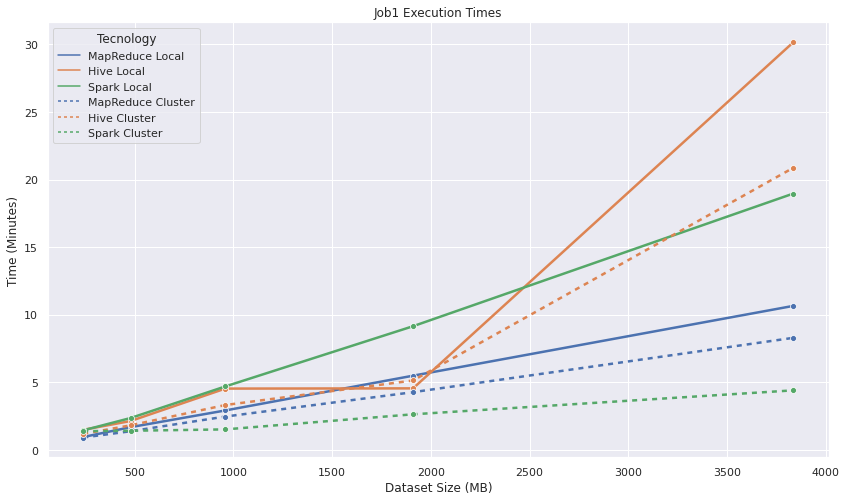

In [6]:
plot_job_benchmark(job1_data, 1)

Anche qui, come per il Job 1, si conferma l'andamento generalmente lineare di tutte le tecnologie usate sia in locale che su cluster.

In particolare si nota come Spark in locale sia tra le esecuzioni più onerose computazionalmente. Su cluster invece per via della grande disponibilità di risorse hardware è con un buon margine la tecnologia più prestante.

Per quanto riguarda MapReduce e Hive si notano miglioramenti minori rispetto alle esecuzioni in locale.

## Job 2 <a name="plot2"></a>

Risultati del secondo job

```
Settore             Anno    Tot. Var. Ticker  Max. Var. Ticker  Max. Volume
BASIC INDUSTRIES    2009    3.482     GURE    709.722   FCX     9141685400.0
BASIC INDUSTRIES    2010    21.790    BLD     519.802   FCX     6891808600.0
BASIC INDUSTRIES    2011   -58.600    ROAD    188.704   FCX     5150807800.0
BASIC INDUSTRIES    2012   -68.788    PATK    261.860   VALE    4659766700.0
BASIC INDUSTRIES    2013    10.322    XRM     416.927   VALE    4428233700.0
BASIC INDUSTRIES    2014   -71.902    BLD     884.599   VALE    5660183200.0
BASIC INDUSTRIES    2015   -48.101    SUM     35191.629 FCX     7286761300.0
BASIC INDUSTRIES    2016    13.829    TECK    451.790   FCX     10464699500.0
BASIC INDUSTRIES    2017    15.279    OPNT    310.178   VALE    7023267600.0
BASIC INDUSTRIES    2018   -3.079     XRM     213.817   VALE    3710091900.0


```

Di seguito il grafico che confronta i tempi di esecuzione al variare della dimensione del dataset, sia in cluster (linee tratteggiate) che in locale (linee piene).

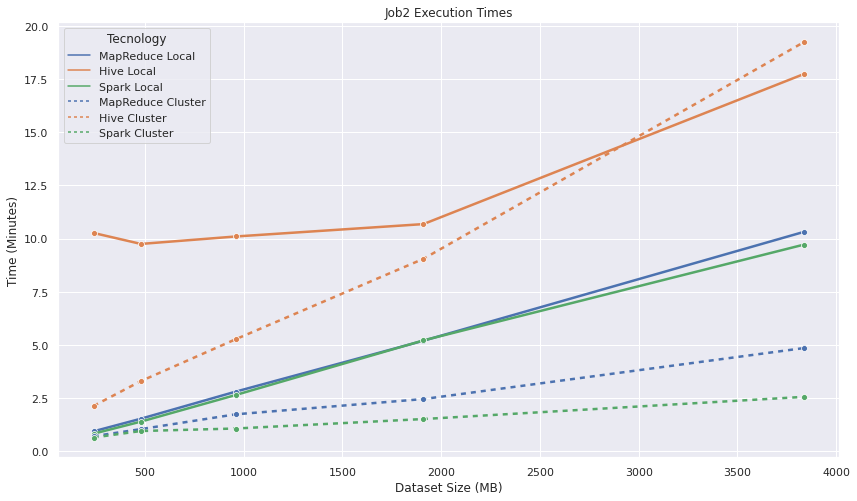

In [7]:
plot_job_benchmark(job2_data, 2)

In questo grafico si può apprezzare in modo migliore l'andamento dei tempi di esecuzione al variare della dimensione di input.

Hive è di gran lunga la tecnologia più onerosa, e i tempi su cluster risultano essere più del doppio della controparte MapReduce e Spark. In locale mantiene per ogni dimensione di input dei tempi estremamente alti, poco abbattibili per via del prodotto cartesiano che bisogna effettuare per il job.

In locale MapReduce e Spark hanno un andamento pressoché identico. Su cluster hanno significativi miglioramenti, dimezzando i tempi di esecuzione di MapReduce, e mostrando prestazioni ancora migliori per Spark.

## Job 3 <a name="plot3"></a>
This is a sub paragraph, formatted in heading 3 style

```
(Ticker1, Ticker2) {Mese: (Var. Perc. Mese 1, Var. Perc. Mese 2), ...}

('OSBCP', 'TCRZ'){
'GEN': (1.678, 1.768), 'FEB': (0.389, 0.077), 'MAR': (0.0, 0.735), 
'APR': (0.875, 1.124), 'MAG': (-0.095, -0.192), 'GIU': (1.156, 0.578), 
'LUG': (0.190, -0.307), 'AGO': (-0.382, 0.269), 'SET': (-0.286, -0.546), 
'OTT': (0.673, 0.387), 'NOV': (-0.095, -0.424), 'DIC': (-0.382, -0.276)}

('OSBCP', 'ISF'){
'GEN': (1.678, 0.832), 'FEB': (0.389, 0.512), 'MAR': (0.0, -0.117), 
'APR': (0.875, 0.698), 'MAG': (-0.095, -0.885), 'GIU': (1.156, 0.310), 
'LUG': (0.190, 0.426), 'AGO': (-0.382, -0.385), 'SET': (-0.286, -0.541), 
'OTT': (0.673, 0.194), 'NOV': (-0.095, -0.233), 'DIC': (-0.382, 0.038)}

('OXLCO', 'VRIG'){
'GEN': (0.078, 0.247), 'FEB': (0.980, 0.159), 'MAR': (-0.583, 0.0), 
'APR': (0.352, 0.433), 'MAG': (-0.039, -0.067), 'GIU': (-0.313, -0.118), 
'LUG': (0.668, -0.079), 'AGO': (-0.078, -0.015), 'SET': (-0.859, 0.075), 
'OTT': (-0.937, -0.051), 'NOV': (-0.828, -0.019), 'DIC': (0.474, 0.003)}

('OXLCO', 'VGSH'){
'GEN': (0.078, 0.214), 'FEB': (0.980, 0.049), 'MAR': (-0.583, 0.197), 
'APR': (0.352, 0.115), 'MAG': (-0.039, 0.164), 'GIU': (-0.313, -0.016), 
'LUG': (0.668, 0.214), 'AGO': (-0.078, 0.164), 'SET': (-0.859, -0.131), 
'OTT': (-0.937, -0.098), 'NOV': (-0.828, -0.148), 'DIC': (0.474, -0.198)}

('OXLCO', 'VCSH'){
'GEN': (0.078, 0.441), 'FEB': (0.980, 0.364), 'MAR': (-0.583, 0.163), 
'APR': (0.352, 0.288), 'MAG': (-0.039, 0.501), 'GIU': (-0.313, 0.087), 
'LUG': (0.668, 0.463), 'AGO': (-0.078, 0.261), 'SET': (-0.859, -0.012), 
'OTT': (-0.937, 0.062), 'NOV': (-0.828, -0.250), 'DIC': (0.474, -0.276)}

('OXLCO', 'CIU'){
'GEN': (0.078, 0.462), 'FEB': (0.980, 0.775), 'MAR': (-0.583, 0.322), 
'APR': (0.352, 0.513), 'MAG': (-0.039, 0.704), 'GIU': (-0.313, 0.009), 
'LUG': (0.668, 0.813), 'AGO': (-0.078, 0.408), 'SET': (-0.859, -0.054), 
'OTT': (-0.937, 0.018), 'NOV': (-0.828, -0.218), 'DIC': (0.474, -0.128)}

('OXLCO', 'ECCB'){
'GEN': (0.078, 0.196), 'FEB': (0.980, 0.765), 'MAR': (-0.583, 0.308), 
'APR': (0.352, 0.193), 'MAG': (-0.039, 0.613), 'GIU': (-0.313, -0.644), 
'LUG': (0.668, 1.006), 'AGO': (-0.078, 0.723), 'SET': (-0.859, -0.643), 
'OTT': (-0.937, -0.950), 'NOV': (-0.828, -0.076), 'DIC': (0.474, 0.114)}

('OXLCO', 'FTSM'){
'GEN': (0.078, 0.033), 'FEB': (0.980, 0.083), 'MAR': (-0.583, -0.016), 
'APR': (0.352, 0.0), 'MAG': (-0.039, -0.016), 'GIU': (-0.313, 0.008), 
'LUG': (0.668, 0.016), 'AGO': (-0.078, 0.016), 'SET': (-0.859, 0.0), 
'OTT': (-0.937, 0.049), 'NOV': (-0.828, -0.016), 'DIC': (0.474, -0.049)}

('OXLCO', 'HYLS'){
'GEN': (0.078, 0.144), 'FEB': (0.980, 1.049), 'MAR': (-0.583, -0.832), 
'APR': (0.352, 0.429), 'MAG': (-0.039, 0.386), 'GIU': (-0.313, -0.606), 
'LUG': (0.668, 0.567), 'AGO': (-0.078, -0.685), 'SET': (-0.859, -0.406), 
'OTT': (-0.937, -0.346), 'NOV': (-0.828, -0.654), 'DIC': (0.474, 0.020)}

('OXLCO', 'HYXE'){
'GEN': (0.078, 0.434), 'FEB': (0.980, 1.196), 'MAR': (-0.583, -1.427), 
'APR': (0.352, 0.868), 'MAG': (-0.039, 0.428), 'GIU': (-0.313, 0.283), 
'LUG': (0.668, 0.767), 'AGO': (-0.078, -0.319), 'SET': (-0.859, -0.286), 
'OTT': (-0.937, -0.009), 'NOV': (-0.828, -0.440), 'DIC': (0.474, -0.351)}
```

Di seguito il grafico che confronta i tempi di esecuzione al variare della dimensione del dataset, sia in cluster (linee tratteggiate) che in locale (linee piene).

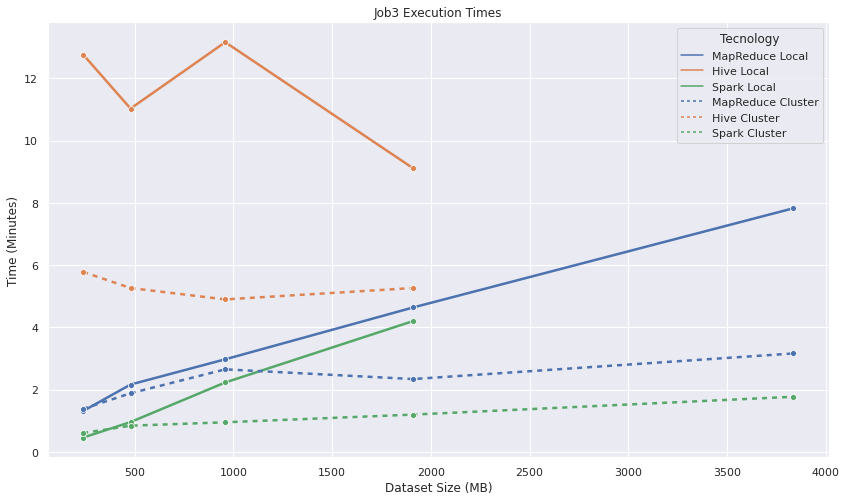

In [8]:
plot_job_benchmark(job3_data, 3)

Il tempo di esecuzione per MapReduce e Spark è lineare al crescere del dataset, e la curva ha una pendenza molto inferiore su cluster, dove si dispone di più risorse hardware.

Si può notare come manchi un datapoint per Spark in locale con il dataset ~4GB. Pur tentando di aumentare la memoria riservata a Spark non si è riusciti ad evitare di sforare il Java Heap size. Si può ipotizzare con confidenza che il risultato sarebbe stato in linea con l'andamento lineare.

Il tempo di esecuzione di Hive per questo job, seppur molto variabile in locale, ha un andamento che sembra quasi costante al variare delle dimensioni del dataset. In realtà, come si vedrà nei seguenti job, il tempo di esecuzione aumenta linearmente con la dimensione del dataset, ma per questo job al diminuire della dimensione del dataset il tempo non diminuisce. 

# Conclusioni <a name="conclusions"></a>

Per quanto riguarda le tecnologie utilizzate si è riscontrato come MapReduce e Spark siano più prestanti di Hive sia in locale che su cluster.

In locale i tempi per eseguire i Job in MapReduce e Spark rislta essere abbastanza simile per i tre Job. Su cluster, dove le risorse hardware sono ben maggiori, si possono apprezzare i benefici di performance di Spark, che fa uso di RDD con caching in memoria. 

Inoltre Spark non vincola il programmatore ad utilizzare un paradigma di tipo Map-Reduce, e consente di effettuare operazioni come il join o il prodotto cartesiano più agevolmente.

Per l'esecuzione su dataset più piccoli (<1GB) non c'è molta differenza tra l'esecuzione in locale e su cluster, mentre solo su dimensioni più grandi si possono apprezzare i benefici di un'architettura distribuita.